In [ ]:
# Importing important libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

# Importing pytorch
import torch           
import torchvision
import torch.nn as nn
import torch.optim as optim            # To implement optimization algorithms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader       # useful to load datas in batches
import torchvision.transforms as transforms   # preprocessing functions on data
from torchvision.datasets import ImageFolder  # Used to convert the folder name as class name 

# training  visualization
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Loading the datasets from directories
train ="/kaggle/input//melanoma/DermMel/train_sep"
test ="/kaggle/input/melanoma/DermMel/test"
valid ="/kaggle/input//melanoma/DermMel/valid"

train_melanoma =  "/kaggle/input//melanoma/DermMel/train_sep/Melanoma"
train_notmelanoma = "/kaggle/input//melanoma/DermMel/train_sep/NotMelanoma"

test_melanoma  = "/kaggle/input/melanoma/DermMel/test/Melanoma"
test_notmelanoma  = "/kaggle/input/melanoma/DermMel/test/NotMelanoma"

val_melanoma = "/kaggle/input//melanoma/DermMel/valid/Melanoma"
val_notmelanoma  = "/kaggle/input//melanoma/DermMel/valid/NotMelanoma"

In [ ]:
print("Number of Melanoma training images -",len(os.listdir(train_melanoma)))
print("Number of Not Melanoma training images -",len(os.listdir(train_notmelanoma)))
print("Number of Melanoma testing images -",len(os.listdir(test_melanoma)))
print("Number of Not Melanoma testing images -",len(os.listdir(test_notmelanoma)))
print("Number of Melanoma validation images -",len(os.listdir(val_melanoma)))
print("Number of Not Melanoma validation images -",len(os.listdir(val_notmelanoma)))

Number of Melanoma training images - 5341
Number of Not Melanoma training images - 5341
Number of Melanoma testing images - 1781
Number of Not Melanoma testing images - 1780
Number of Melanoma validation images - 1781
Number of Not Melanoma validation images - 1781


In [ ]:
IMAGE_SIZE=(224,224)                 

In [ ]:
def images_transforms(phase):
    if phase == 'train':
        data_transformation =transforms.Compose([
            # Resizing the all the images to same size
            transforms.Resize(IMAGE_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            # covert the PIL images to torch Tensors
            transforms.ToTensor(),
            
            #Normalizes the pixel values from the range [0,255] to [0,1]
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        ])
    else:
        data_transformation=transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
        ])
        
    
    return data_transformation

In [ ]:
# Datasets for training and validation

Train = datasets.ImageFolder(train, transform=images_transforms('train'))
Valid = datasets.ImageFolder(valid, transform=images_transforms('test'))

In [ ]:
print(Train)
print(Valid)

Dataset ImageFolder
    Number of datapoints: 10682
    Root location: /kaggle/input//melanoma/DermMel/train_sep
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset ImageFolder
    Number of datapoints: 3562
    Root location: /kaggle/input//melanoma/DermMel/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


In [ ]:
print(len(Train.classes))

2


In [ ]:
image, label = Train[0]
print(image.size(), label)

torch.Size([3, 224, 224]) 0


In [ ]:
image, label = Train[5000]
print(image.size(), label)

torch.Size([3, 224, 224]) 0


In [ ]:
# Checking some images from Training dataset

def show_image(image, label):
    
    img_grid = torchvision.utils.make_grid(torch.tensor(image))
    img_grid_np = img_grid.numpy()                 
    img_grid_np = np.transpose(img_grid_np, (1,2,0)) 

    plt.imshow(img_grid_np)
    plt.plot()
    
    print("Label:" + Train.classes[label] + "(" + str(label) + ")")

Label:Melanoma(0)


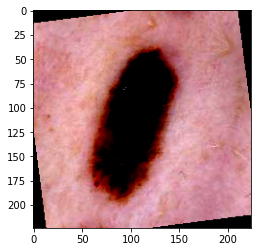

In [ ]:
show_image(*Train[0])

Label:Melanoma(0)


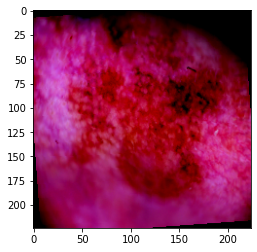

In [ ]:
show_image(*Train[5000])

Label:NotMelanoma(1)


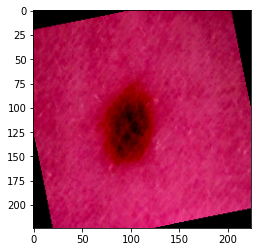

In [ ]:
show_image(*Train[7000])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Dataloader for training and validation

Train_loader = DataLoader(Train,
                          batch_size=32,
                          shuffle=True,
                          num_workers=2)
Valid_loader = DataLoader(Valid,
                          batch_size=32,
                          shuffle=False,
                          num_workers=2)

In [ ]:
imgs, lbls = next(iter(Train_loader))

print(imgs.size(), lbls.size())

torch.Size([32, 3, 224, 224]) torch.Size([32])


tensor([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0])


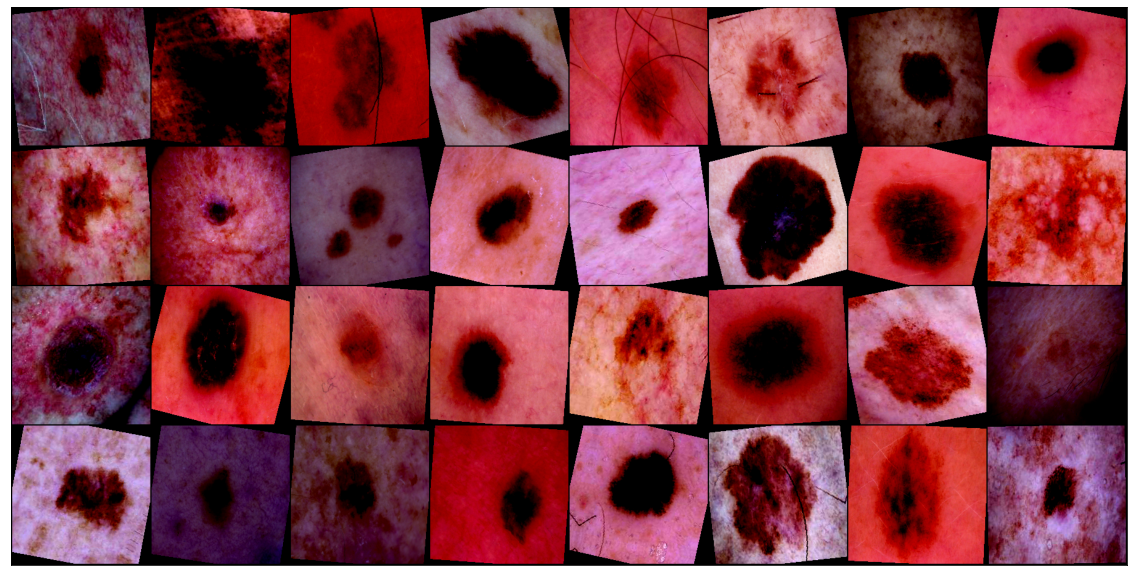

In [ ]:
# Visualizing the images from 1st Batch

img_grid = torchvision.utils.make_grid(torch.tensor(imgs), nrow=8)

img_grid_np = img_grid.numpy()      # converting tensors into numpy bcoz matpot lib wont work in tensors           
img_grid_np = np.transpose(img_grid_np, (1,2,0)) # from [channels, height, width] => [height, weight, channels]

fig , ax = plt.subplots(figsize=(20,20))
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(img_grid_np)
plt.plot()
print(lbls)

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # [N, 32, (224-3+2)+1, (224-3+2)+1] = [N, 32, 224, 224  ]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), # [N, 32, (256-3+2)+1, (256-3+2)+1] = [N, 32, 224, 224]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),                                                      # [N, 32, 224/2, 224/2] = [N, 32, 112, 112]
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # [N, 64, (112-3+2)+1, (112-3+2)+1] = [N, 64, 112, 112]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # [N, 64, (112-3+2)+1, (112-3+2)+1] = [N, 64, 112, 112]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),                                                      # [N, 64, 112/2, 112/2] = [N, 64, 56, 56]
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),# [N, 128, (56-3+2)+1, (56-3+2)+1] = [N, 128, 56, 56]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),# [N, 128, (56-3+2)+1, (56-3+2)+1] = [N, 128, 56, 56]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),                                                       # [N, 128, 56/2, 56/2] = [N, 128, 28, 28]
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),# [N, 256, (28-3+2)+1, (28-3+2)+1] = [N, 256, 28, 28]
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),# [N, 256, (28-3+2)+1, (28-3+2)+1] = [N, 256, 28, 28]
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)                                                        #[N, 256, 28/2, 28/2] = [N, 256, 14, 14]
            
        )

        self.dense_layers = nn.Sequential(
            nn.Flatten(),                # [N, 256*14*14] = [N, 50176]
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),      # [N, 20000]
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 2)          # [N, 38]
        )

    def forward(self, X):
        # Convolution layers
        out = self.conv_layers(X)
        
        # Fully connected layers
        out = self.dense_layers(out)

        return out

In [ ]:
model = CNN_Model()
model

CNN_Model(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
out = model(imgs)
out.size()

torch.Size([32, 2])

In [ ]:
def evaluate_on_gpu(model,dataloader):
  
  total,correct=0,0

 # Setting the model to "Eval" mode
 ## Turns OFF BatchNorm and Dropout
  model.eval()

  for batch in dataloader:

    image,labels=batch
    image,labels=image.to(device),labels.to(device)
    
    out_probs=model(image)
    out_labels=torch.argmax(out_probs,axis=1)
    total+=labels.size(0)
    correct+=(labels==out_labels).sum().item()
    
  return 100*correct/total

In [ ]:
import copy
def train_on_gpu(model,loss_criterion,optimizer,Train_loader,Valid_loader,epochs,modelname):
  hist={'loss':[],
        'train_acc':[],
        'valid_acc':[]}
  min_loss=10000  

# Training loops
  for epochs_num in tqdm(range(1,epochs+1),desc='training last layer',total=epochs):
    losses=[]
   
    ### Start of Epoch ###
    for batch in Train_loader:
      images,labels = batch
      images, labels = images.to(device), labels.to(device)
        
     # Setting the model to "Train" mode
     ## Turns ON BatchNorm and Dropout
      model.train()
            
     #Forward Propogation
      out = model(images)
      loss=loss_criterion(out,labels)
    
     # Storing the loss value for each batch
      losses.append(loss.item())
        
     #Back Propogation
      optimizer.zero_grad()
      loss.backward()
    
     # Update weights
      optimizer.step()

     # Deleting some variables and clearing the GPU RAM
     ## Just to prevent out of memory errors as we are dealing
     ## With such large number of parameters and data
      del images,labels,out
      torch.cuda.empty_cache()
    ### End of epoch ###

    curr_epoch_loss=np.array(losses).mean() 

    hist['loss'].append(curr_epoch_loss)
    train_acc=evaluate_on_gpu(model,Train_loader)
    valid_acc=evaluate_on_gpu(model,Valid_loader)
    hist['train_acc'].append(train_acc)
    hist['valid_acc'].append(valid_acc)
    print('Epoch : {0} | Training Loss : {1:.4f} | Train Accuracy : {2:.4f} | Valid Accuracy : {3:.4f}'.format(epochs_num, curr_epoch_loss, train_acc, valid_acc))

    # Model CheckPointing
    ## Saving the model's weights when we encounter a minimum loss
    if curr_epoch_loss<min_loss:

      min_loss=curr_epoch_loss
      best_model=copy.deepcopy(model.state_dict())

# Visualizing the losses and accuracies
  fig, ax=plt.subplots(ncols=2, figsize=(12,6))

  ax[0].plot(range(1,epochs+1),hist['loss'],'g-',label='loss')
  ax[0].plot(range(1,epochs+1),np.ones(epochs)*min_loss,'b-',alpha=0.6,label='min_loss={}'.format(min_loss))
  ax[0].grid()
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('loss value')
  ax[0].set_title('epochs vs. loss value')
  ax[0].legend()

  ax[1].plot(range(1,epochs+1),hist['train_acc'],'r-',alpha=0.8,label='training accuracy')
  ax[1].plot(range(1,epochs+1),hist['valid_acc'],'m-',alpha=0.8,label='valid accuracy')
  ax[1].grid()
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('accuracy')
  ax[1].set_title('epochs vs accurracy')
  ax[1].legend()

  plt.plot()

  torch.save(best_model,'{0}_{1:.4f}.pth'.format(modelname,min_loss))
  print("best loss value:{}".format(min_loss))
  
  return best_model

training last layer:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 | Training Loss : 1.1433 | Train Accuracy : 82.4752 | Valid Accuracy : 82.2291
Epoch : 2 | Training Loss : 0.4922 | Train Accuracy : 81.5484 | Valid Accuracy : 81.3869
Epoch : 3 | Training Loss : 0.5743 | Train Accuracy : 73.8626 | Valid Accuracy : 73.1892
Epoch : 4 | Training Loss : 0.5220 | Train Accuracy : 82.2973 | Valid Accuracy : 82.3414
Epoch : 5 | Training Loss : 0.4558 | Train Accuracy : 86.5194 | Valid Accuracy : 87.5912
Epoch : 6 | Training Loss : 0.3669 | Train Accuracy : 90.1236 | Valid Accuracy : 89.5564
Epoch : 7 | Training Loss : 0.3215 | Train Accuracy : 85.0309 | Valid Accuracy : 86.8052
Epoch : 8 | Training Loss : 0.3076 | Train Accuracy : 90.2640 | Valid Accuracy : 90.5671
Epoch : 9 | Training Loss : 0.2848 | Train Accuracy : 90.9099 | Valid Accuracy : 90.5109
Epoch : 10 | Training Loss : 0.2539 | Train Accuracy : 89.9176 | Valid Accuracy : 90.5671
Epoch : 11 | Training Loss : 0.2566 | Train Accuracy : 92.6606 | Valid Accuracy : 92.3919
Epoch : 12 | Traini

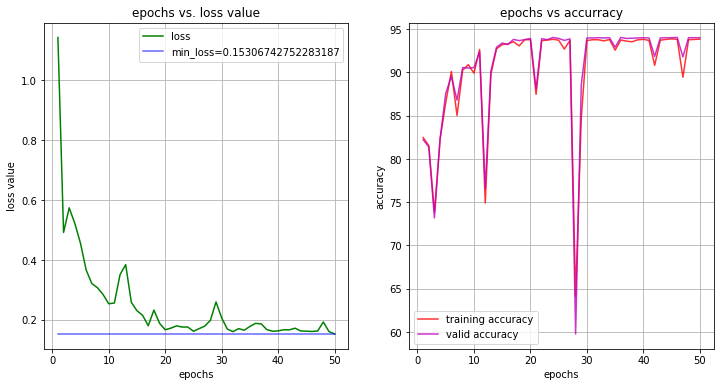

In [ ]:
model = model.to(device)

loss_criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

# Training the model for 50 epochs

model_wts=train_on_gpu(model ,loss_criterion,optimizer,Train_loader,Valid_loader,50,'best_model')

In [ ]:
def images_transforms1(phase):
    if phase == 'test':
        data_transformation =transforms.Compose([
            transforms.ToTensor()
        ])
    
    return data_transformation

In [ ]:
test_batch = datasets.ImageFolder(test, transform=images_transforms('test'))
len(test_batch)

3561

In [ ]:
def predict_image_class_label(img, model):
    
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(device)
    
    # Get predictions from model
    yb = best_model(xb)
    
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    
    return preds[0].item()

In [ ]:
# Storing the true labels
true_labels=[]
for i in range(len(test_batch)):
    true_labels.append(test_batch[i][1])
    
# Making predictions on test dataset and store the labels
pred_labels=[]    
for i in range(len(test_batch)):
    pred_labels.append(predict_image_class_label(test_batch[i][0],model))

In [ ]:
print('Confusion Matrix : \n',confusion_matrix(true_labels,pred_labels),'\n\n')

Confusion Matrix : 
 [[1544  237]
 [   0 1780]] 




In [ ]:
print('Accuracy Score : ',accuracy_score(true_labels,pred_labels)*100,'%','\n\n')

print('Classification Report : \n',classification_report(true_labels,pred_labels),'\n\n')


Accuracy Score :  93.34456613310867 % 


Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93      1781
           1       0.88      1.00      0.94      1780

    accuracy                           0.93      3561
   macro avg       0.94      0.93      0.93      3561
weighted avg       0.94      0.93      0.93      3561
 




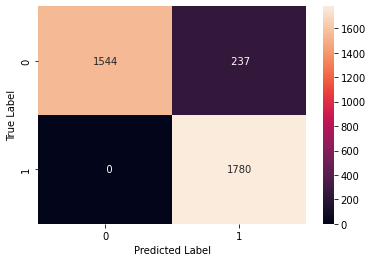

<Figure size 432x288 with 0 Axes>

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, fmt='4',annot=True).set(ylabel="True Label", xlabel="Predicted Label") 
plt.show() 
plt.savefig('confusion_matrix.jpg')